# Importing , Training & Saving the Pre-Trained Model

## Installing Libraries

In [1]:
%pip install transformers
%pip install -q datasets transformers
%pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 17.6 MB/s 
     |████████████████████████████████| 7.6 MB 57.8 MB/s 
     |████████████████████████████████| 182 kB 49.5 MB/s 
     |████████████████████████████████| 451 kB 34.9 MB/s 
     |████████████████████████████████| 132 kB 59.5 MB/s 
     |████████████████████████████████| 212 kB 74.4 MB/s 
     |████████████████████████████████| 127 kB 17.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from huggingface_hub import notebook_login
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, DefaultDataCollator , TrainingArguments, Trainer
from google.colab import drive
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from datasets import load_metric, load_dataset
import os

## Loading fashion-minst Dataset

In [3]:
dataset = load_dataset("fashion_mnist")
dataset

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
dataset["train"][2]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7FB178BEFC40>,
 'label': 0}

In [5]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [6]:
dataset["train"][2]['image']

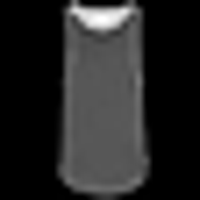

In [7]:
dataset["train"][2]['image'].resize((200, 200))

In [8]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'Pullover'

## Load Metric

In [9]:
#loading the metrics accuracy
metric = load_metric("accuracy")

<ipython-input-9-45472ef377a3>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


## Load Feature Extractor

In [10]:
extractor = AutoFeatureExtractor.from_pretrained("google/mobilenet_v2_1.0_224")
extractor

Downloading:   0%|          | 0.00/406 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

MobileNetV2ImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "MobileNetV2ImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}

## Preprocessing 

In [11]:
#normalizing the images
normalize = Normalize(mean=extractor.image_mean, std=extractor.image_std)
_transforms = Compose([RandomResizedCrop((224,224)), ToTensor(), normalize])

In [12]:
def transforms(data):
    data["pixel_values"] = [_transforms(img.convert("RGB")) for img in data["image"]]
    del data["image"]
    return data

In [13]:
dataset = dataset.with_transform(transforms)

In [14]:
dataset['train'][2]

{'label': 0,
 'pixel_values': tensor([[[-0.4745, -0.4745, -0.4745,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4745, -0.4745, -0.4745,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4745, -0.4745, -0.4745,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.3176, -0.3176, -0.3176,  ..., -1.0000, -1.0000, -1.0000],
          [-0.3176, -0.3176, -0.3176,  ..., -1.0000, -1.0000, -1.0000],
          [-0.3176, -0.3176, -0.3176,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-0.4745, -0.4745, -0.4745,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4745, -0.4745, -0.4745,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4745, -0.4745, -0.4745,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.3176, -0.3176, -0.3176,  ..., -1.0000, -1.0000, -1.0000],
          [-0.3176, -0.3176, -0.3176,  ..., -1.0000, -1.0000, -1.0000],
          [-0.3176, -0.3176, -0.3176,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-0.4745, -0.4745, -0.4745,  ..., -1.0000, -1.0000, -1.0000],

In [15]:
data_collator = DefaultDataCollator()

In [16]:
dataset['train'][2]

{'label': 0, 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]])}

## Evaluating Function

In [17]:
predictions = 0
real_labels = 0

In [28]:
#In this compute_metrics function,Tuple is taken as input ,predictions are model logits ,label_ids are lables representings the classes
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    global predictions
    global real_labels
    predictions = np.argmax(eval_pred.predictions, axis=1)
    real_labels = eval_pred.label_ids
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)




## Training the Model

In [19]:
#model and batch size is inialized
model_checkpoint='google/mobilenet_v2_1.0_224'
batch_size = 32 

In [20]:
#pixel values and labels are keys used in each Batch, DATA_COLLATOR is used to batch these data instances together.
model = AutoModelForImageClassification.from_pretrained(
    "google/mobilenet_v2_1.0_224",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True,
)

Downloading:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([10, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
#training arguments given and 10 epochs mentioned with a batch size of 32
training_args = TrainingArguments(
    output_dir="./results",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [29]:
#All the arguents passedto trainer with model name
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=extractor,
    compute_metrics=compute_metrics
)


In [ ]:
#Model is saved after each epoch as checkpoint
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 60000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 4680
  Number of trainable parameters = 2236682


Epoch,Training Loss,Validation Loss,Accuracy
0,0.960500,0.890014,0.687000
1,0.659400,0.645630,0.767800
2,0.602200,0.578433,0.794000
3,0.550700,0.522977,0.811200
4,0.501700,0.485267,0.827900
5,0.507000,0.478762,0.828600
6,0.492100,0.488447,0.820800
7,0.524500,0.484838,0.828100
8,0.499500,0.459751,0.832200
9,0.452600,0.471837,0.835800


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-468
Configuration saved in ./results/checkpoint-468/config.json
Model weights saved in ./results/checkpoint-468/pytorch_model.bin
Image processor saved in ./results/checkpoint-468/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-936
Configuration saved in ./results/checkpoint-936/config.json
Model weights saved in ./results/checkpoint-936/pytorch_model.bin
Image processor saved in ./results/checkpoint-936/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-1404
Configuration saved in ./results/checkpoint-1404/config.json
Model weights saved in ./results/checkpoint-1404/pytorch_model.bin
Image processor saved in ./results/checkpoint-1404/preprocessor_config.json
***** Running Evaluat

***** train metrics *****
  epoch                    =         10.0
  total_flos               = 1128638010GF
  train_loss               =       0.6861
  train_runtime            =   0:35:51.62
  train_samples_per_second =      278.859
  train_steps_per_second   =        2.175


In [30]:
#triner loading the best checkpoint and giving evlaution results
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32


***** eval metrics *****
  eval_accuracy           =     0.0745
  eval_loss               =     2.3985
  eval_runtime            = 0:00:33.37
  eval_samples_per_second =    299.605
  eval_steps_per_second   =      9.378


# Evaluation

In [24]:
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score

In [31]:
type(predictions)

numpy.ndarray

In [32]:
accuracy , precision, recall, f1 = accuracy_score(real_labels , predictions), precision_score(real_labels , predictions, average='macro'), recall_score(real_labels , predictions, average='macro'), f1_score(real_labels , predictions, average='macro')

In [33]:
"Accuracy : {}, Precision : {}, Recall : {}, F1 score : {}".format(accuracy , precision, recall, f1)

'Accuracy : 0.0745, Precision : 0.08412352443592278, Recall : 0.0745, F1 score : 0.05863798687898567'

## Save the Trained Model

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Collab Notebooks/Model

/content/drive/MyDrive/Collab Notebooks/Model


In [ ]:
trainer.save_model("model1")

Saving model checkpoint to model1
Configuration saved in model1/config.json
Model weights saved in model1/pytorch_model.bin
Image processor saved in model1/preprocessor_config.json


###Save Entire Model

In [ ]:
torch.save(model, "./model_full.pt")

### Load Entire Model

In [ ]:
model_full = torch.load("./model_full.pt")
model_full.eval()

MobileNetV2ForImageClassification(
  (mobilenet_v2): MobileNetV2Model(
    (conv_stem): MobileNetV2Stem(
      (first_conv): MobileNetV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (conv_3x3): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (reduce_1x1): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
      )
    )
    (layer): ModuleList(
      (0): MobileNetV2InvertedResidual(
        (expand_1x1): MobileNe

## Predict

In [ ]:
dataset1 = load_dataset("fashion_mnist")

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
image = dataset1["train"][3]['image']
encoding = extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
inputs = encoding.to(device)

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
with torch.no_grad():
  outputs = model(**inputs)
  logits = outputs.logits

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Dress


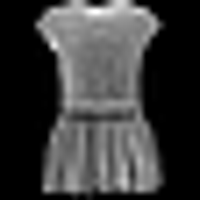

In [ ]:
dataset1["train"][3]['image'].resize((200, 200))

## Push model to huggingface

In [ ]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
%%capture
%sudo apt -qq install git-lfs
%git config --global credential.helper store

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to ./results
Configuration saved in ./results/config.json
Model weights saved in ./results/pytorch_model.bin
Image processor saved in ./results/preprocessor_config.json


# Use Trained Model

## Install Libraries

In [34]:
%pip install transformers datasets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Libraries

In [36]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, DefaultDataCollator , TrainingArguments, Trainer
import torch
from datasets import load_metric, load_dataset
from PIL import Image
import requests
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [37]:
repo_name = "Methmani/ImageClassification_fashion-mnist"

#Model and feature extractor is loaded 
feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
trained_model = AutoModelForImageClassification.from_pretrained(repo_name)

Downloading:   0%|          | 0.00/406 [00:00<?, ?B/s]

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--Methmani--ImageClassification_fashion-mnist/snapshots/8d0c45954f115ae4a06648060c702a2545f3dd6d/preprocessor_config.json


Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Methmani--ImageClassification_fashion-mnist/snapshots/8d0c45954f115ae4a06648060c702a2545f3dd6d/config.json
Model config MobileNetV2Config {
  "_name_or_path": "Methmani/ImageClassification_fashion-mnist",
  "architectures": [
    "MobileNetV2ForImageClassification"
  ],
  "classifier_dropout_prob": 0.8,
  "depth_divisible_by": 8,
  "depth_multiplier": 1.0,
  "expand_ratio": 6,
  "finegrained_output": true,
  "first_layer_is_expansion": true,
  "hidden_act": "relu6",
  "id2label": {
    "0": "T - shirt / top",
    "1": "Trouser",
    "2": "Pullover",
    "3": "Dress",
    "4": "Coat",
    "5": "Sandal",
    "6": "Shirt",
    "7": "Sneaker",
    "8": "Bag",
    "9": "Ankle boot"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "Ankle boot": 9,
    "Bag": 8,
    "Coat": 4,
    "Dress": 3,
    "Pullover": 2,
    "Sandal": 5,
    "Shirt": 6,
    "Sneaker": 7,
    "T - shirt / 

Downloading:   0%|          | 0.00/9.19M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--Methmani--ImageClassification_fashion-mnist/snapshots/8d0c45954f115ae4a06648060c702a2545f3dd6d/pytorch_model.bin
All model checkpoint weights were used when initializing MobileNetV2ForImageClassification.

All the weights of MobileNetV2ForImageClassification were initialized from the model checkpoint at Methmani/ImageClassification_fashion-mnist.
If your task is similar to the task the model of the checkpoint was trained on, you can already use MobileNetV2ForImageClassification for predictions without further training.


## Load the Dataset

In [39]:
newDataset = load_dataset("fashion_mnist")

  0%|          | 0/2 [00:00<?, ?it/s]

## Import Image from Dataset to Predict

In [ ]:
image = newDataset["test"][40]['image']

## Import Image from a url to Predict

In [ ]:
from PIL import Image
import requests

#image url is given and viewed to predict
url = 'https://eadn-wc03-1927607.nxedge.io/cdn/pub/media/catalog/product/cache/829a858ace69687aab10d7219e5dff7a/_/k/_k8a0477-croc-tshirts-apr.jpg'

image = Image.open(requests.get(url, stream=True).raw)

## View Image

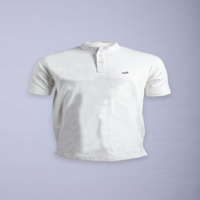

In [ ]:
image.resize((200, 200))

## Transform the Image

In [ ]:
# image is preprocessed using feature extractor
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


## Predict

In [ ]:
#getting the output of the model 
with torch.no_grad():
  outputs = trained_model(**encoding)
  logits = outputs.logits

In [ ]:
#predicting the input with argmax
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", trained_model.config.id2label[predicted_class_idx])

Predicted class: T - shirt / top


# Evaluation

In [41]:
predictions = 0
real_labels = 0

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    global predictions
    global real_labels
    predictions = np.argmax(eval_pred.predictions, axis=1)
    real_labels = eval_pred.label_ids
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_transforms = Compose([RandomResizedCrop((224,224)), ToTensor(), normalize])

def transforms(data):
    data["pixel_values"] = [_transforms(img.convert("RGB")) for img in data["image"]]
    del data["image"]
    return data

dataset2 = newDataset.with_transform(transforms)

model_checkpoint = repo_name
batch_size = 32 
data_collator = DefaultDataCollator()

training_args = TrainingArguments(
    output_dir="./results",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=trained_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset2["train"],
    eval_dataset=dataset2["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [42]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32


***** eval metrics *****
  eval_accuracy           =     0.8258
  eval_loss               =      0.483
  eval_runtime            = 0:00:36.96
  eval_samples_per_second =    270.509
  eval_steps_per_second   =      8.467


## Confusion matrix for testing dataset

In [43]:
confusion_matrix = confusion_matrix(real_labels, predictions)

In [44]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

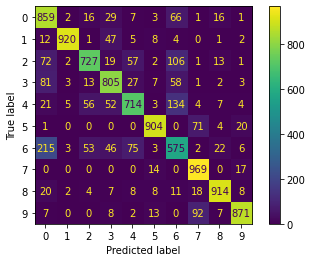

In [45]:
cm_display.plot()
plt.show()

## Evaluate testing dataset

In [46]:
accuracy , precision, recall, f1 = accuracy_score(real_labels , predictions), precision_score(real_labels , predictions, average='macro'), recall_score(real_labels , predictions, average='macro'), f1_score(real_labels , predictions, average='macro')

In [47]:
"Accuracy : {}, Precision : {}, Recall : {}, F1 score : {}".format(accuracy , precision, recall, f1)

'Accuracy : 0.8258, Precision : 0.8312953191027465, Recall : 0.8257999999999999, F1 score : 0.8259608964568829'

## Evaluate training dataset

In [48]:
trainer = Trainer(
    model=trained_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset2["train"],
    eval_dataset=dataset2["train"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

accuracy , precision, recall, f1 = accuracy_score(real_labels , predictions), precision_score(real_labels , predictions, average='macro'), recall_score(real_labels , predictions, average='macro'), f1_score(real_labels , predictions, average='macro')

"Accuracy : {}, Precision : {}, Recall : {}, F1 score : {}".format(accuracy , precision, recall, f1)


***** Running Evaluation *****
  Num examples = 60000
  Batch size = 32


***** eval metrics *****
  eval_accuracy           =     0.8349
  eval_loss               =     0.4513
  eval_runtime            = 0:03:28.62
  eval_samples_per_second =    287.592
  eval_steps_per_second   =      8.987


'Accuracy : 0.8349, Precision : 0.8401833338178033, Recall : 0.8349, F1 score : 0.8350862597976283'